In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [3]:
#import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [6]:
# -------- 1. Load AG News --------
(train_ds, test_ds), info = tfds.load(
    'ag_news_subset',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [7]:
def clean_text(text):
    text = text.lower()                                 # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)                # Remove punctuation/numbers
    tokens = text.split()                               # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens) 

def tf_clean_text(text, label):
    # Decode bytes, clean, and re-encode as tf.string
    clean = tf.py_function(func=lambda x: clean_text(x.numpy().decode("utf-8")),
                           inp=[text],
                           Tout=tf.string)
    clean.set_shape([])  
    return clean, label


clean_train_ds = train_ds.map(tf_clean_text)
clean_test_ds = test_ds.map(tf_clean_text)

In [40]:
for text, label in clean_train_ds.take(1):
    print("Cleaned Text:", text.numpy().decode("utf-8"))
    print("Label:", label.numpy())

Cleaned Text: amd new dualcore opteron chip designed mainly corporate computing applications including databases web services financial transactions
Label: 3


In [41]:
for text, label in train_ds.take(1):
    print("Original Text:", text.numpy().decode("utf-8"))
    print("Label:", label.numpy())

Original Text: AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.
Label: 3


In [10]:
def generate_wordclouds(dataset, file_name):

    # Collect text for each category
    category_texts = {i: [] for i in range(4)}
    for text, label in dataset:
        # Convert label to a hashable type (e.g., int)
        category_texts[label.numpy().item()].append(text.numpy().decode('utf-8')) # Changed line

    # Generate and plot wordclouds
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(4):
        combined_text = ' '.join(category_texts[i])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
        axs[i].imshow(wordcloud, interpolation='bilinear')
        # Assuming CATEGORY_NAMES is defined elsewhere
        axs[i].set_title(info.features['label'].names[i])  # Changed line to get category names from info
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()


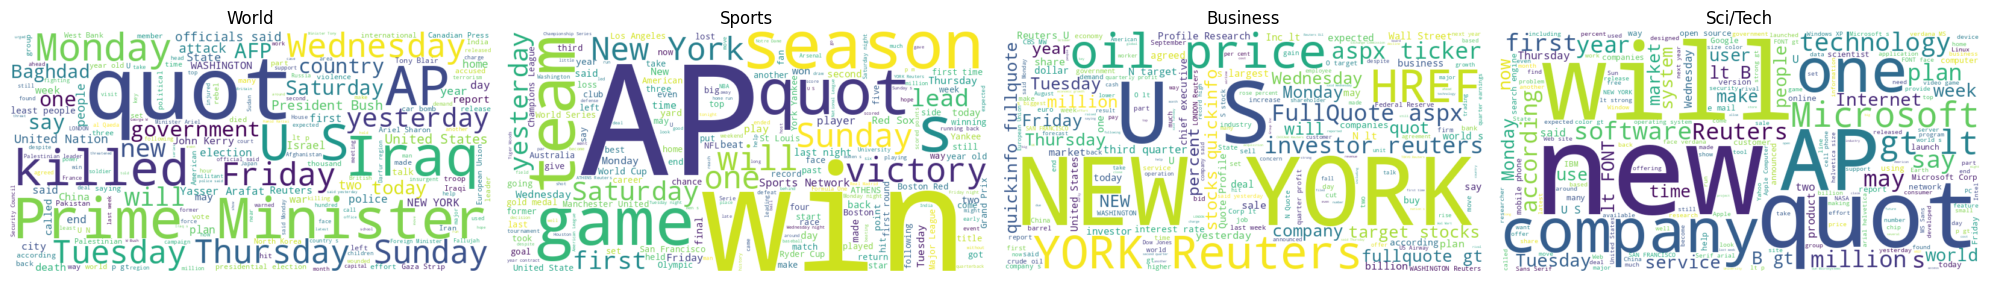

In [11]:
generate_wordclouds(train_ds, 'train_dataset_wordclouds.png')

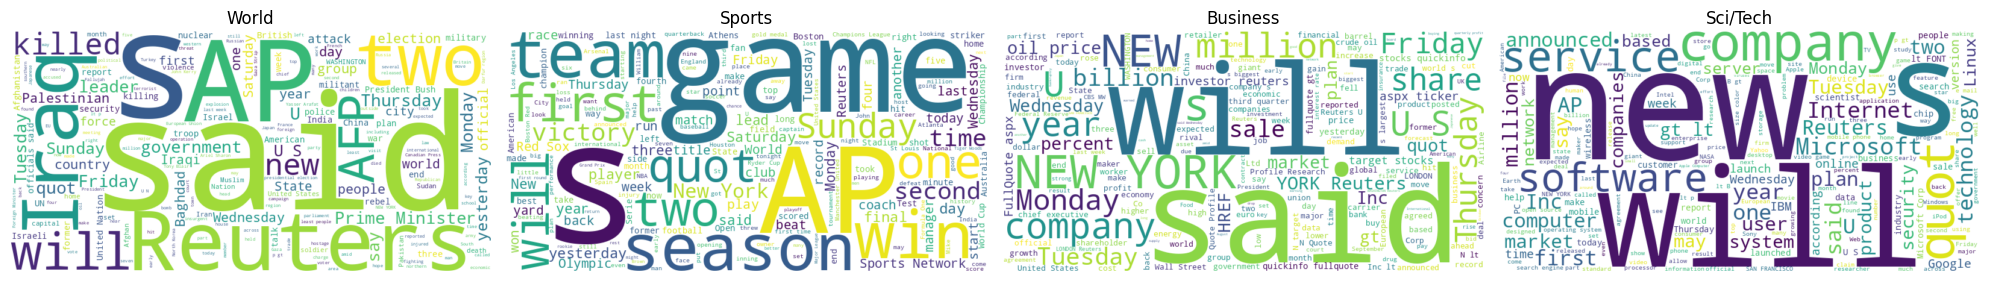

In [42]:
generate_wordclouds(test_ds, 'test_dataset_wordclouds.png')

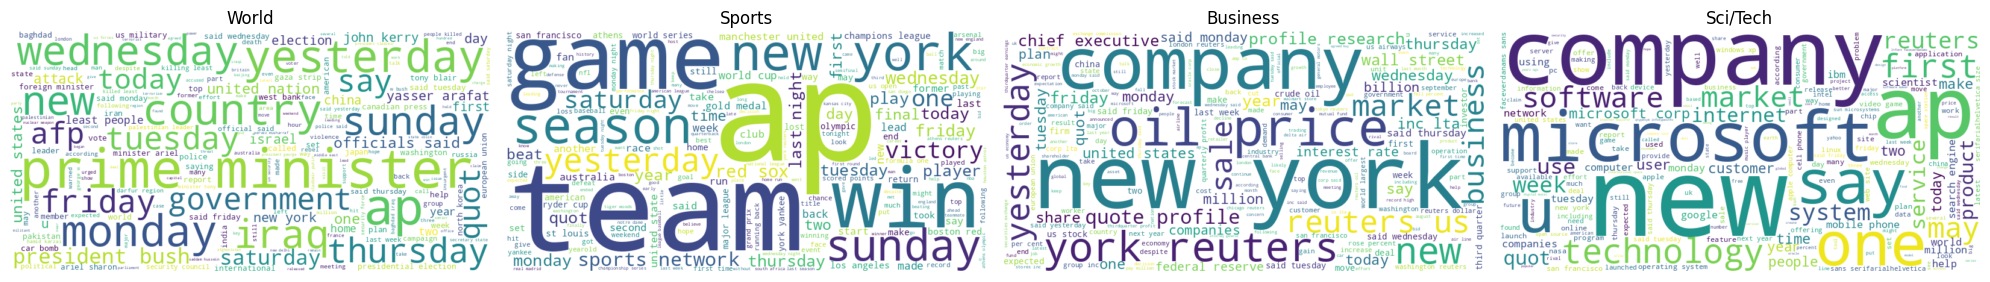

In [13]:
generate_wordclouds(clean_train_ds, 'clean_train_dataset_wordclouds.png')

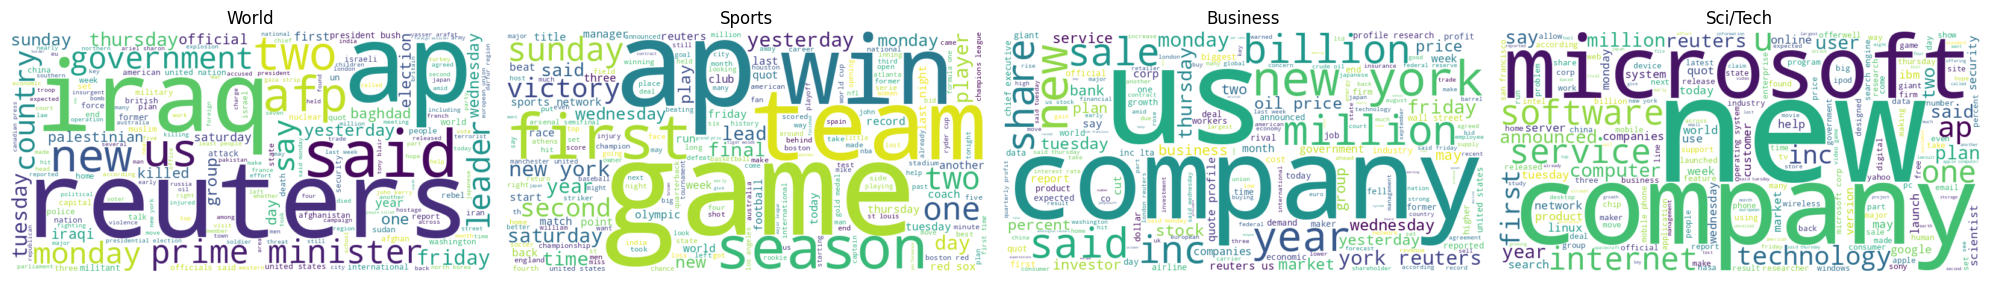

In [14]:
generate_wordclouds(clean_test_ds, 'clean_test_dataset_wordclouds.png')

In [15]:
from collections import Counter

def plot_distribution(data, title="Data Distribution", ylabel="Frequency", filename="None"):
    # Extract integer labels
    labels = [label.numpy().item() for _, label in data]
    counts = Counter(labels)
    
    # Convert to label names
    category_names = [info.features['label'].names[i] for i in sorted(counts)]
    frequencies = [counts[i] for i in sorted(counts)]

    # Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x=category_names, y=frequencies, palette="pastel", edgecolor="black", width=0.5)
    plt.title(title)
    plt.xlabel("Category")
    plt.ylabel(ylabel)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

    if filename:
        plt.savefig(filename)
        plt.close()

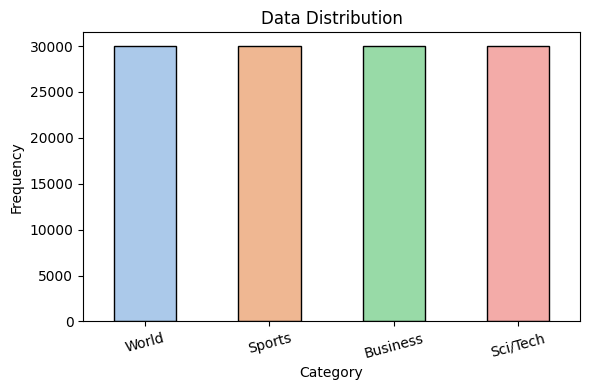

In [16]:
plot_distribution(train_ds)

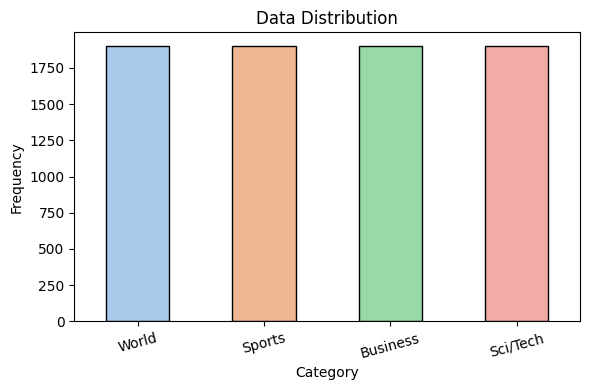

In [43]:
plot_distribution(test_ds)

In [18]:
# -------- 2. Preprocessing --------
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=20000,
    output_sequence_length=128
)

# Adapt tokenizer on train text
text_ds = train_ds.map(lambda text, label: text)
tokenizer.adapt(text_ds)

# Format the dataset for training
def preprocess(text, label):
    return tokenizer(text), tf.one_hot(label, depth=4)

train_tokenized = train_ds.map(preprocess).batch(64).prefetch(tf.data.AUTOTUNE)
test_tokenized = test_ds.map(preprocess).batch(64).prefetch(tf.data.AUTOTUNE)

In [20]:
# -------- 3. Scaled Dot-Product Attention Layer --------
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, q, k, v, mask=None):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        d_k = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_logits = matmul_qk / tf.math.sqrt(d_k)

        if mask is not None:
            scaled_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output

In [21]:
class LSTMAttentionModel(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.bi_lstm = tf.keras.layers.Bidirectional(
            layer=tf.keras.layers.LSTM(
                hidden_dim,
                return_sequences=True))
        self.q_proj = tf.keras.layers.Dense(hidden_dim)
        self.k_proj = tf.keras.layers.Dense(hidden_dim)
        self.v_proj = tf.keras.layers.Dense(hidden_dim)
        self.attention = ScaledDotProductAttention()
        self.pooling = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1))
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.embedding(x)
        x = self.bi_lstm(x)
        q, k, v = self.q_proj(x), self.k_proj(x), self.v_proj(x)
        x = self.attention(q, k, v)
        x = self.pooling(x)
        return self.classifier(x)

In [28]:
class GRUAttentionModel(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.bi_gru = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(hidden_dim, return_sequences=True))
        self.q_proj = tf.keras.layers.Dense(hidden_dim)
        self.k_proj = tf.keras.layers.Dense(hidden_dim)
        self.v_proj = tf.keras.layers.Dense(hidden_dim)
        self.attention = ScaledDotProductAttention()
        self.pooling = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1))
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.embedding(x)
        x = self.bi_gru(x)
        q, k, v = self.q_proj(x), self.k_proj(x), self.v_proj(x)
        x = self.attention(q, k, v)
        x = self.pooling(x)
        return self.classifier(x)

In [22]:
# Define EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',        # You can also monitor 'val_accuracy'
    patience=3,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

In [81]:
for text, label in train_tokenized.take(1):
    #print("Original Text:", text.numpy().decode("utf-8"))
    print("Label:", text.numpy())

Label: [[1688   11   21 ...    0    0    0]
 [  28  160  140 ...    0    0    0]
 [  65  184   11 ...    0    0    0]
 ...
 [5175 1454 1687 ...    0    0    0]
 [1384    5 2961 ...    0    0    0]
 [  35 4718    1 ...    0    0    0]]


In [74]:
model_lstm = LSTMAttentionModel(vocab_size=20000, embed_dim=128, hidden_dim=128, num_classes=4)
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.build(input_shape=(None, 128))

# -------- 5. Train LSTM + Attention layer --------
history_lstm = model_lstm.fit(train_tokenized, epochs=10, validation_data=test_tokenized, callbacks=[early_stop])

# -------- 6. Evaluate --------
loss, acc = model_lstm.evaluate(test_tokenized)
print(f"Test Accuracy: {acc:.4f}")

Epoch 1/10
  15/1875 ━━━━━━━━━━━━━━━━━━━━ 6:20 205ms/step - accuracy: 0.2804 - loss: 1.3907

KeyboardInterrupt: 

In [53]:
model_lstm.save("lstm_attention_model.keras")

In [54]:
model_lstm.save_weights("lstm_attention.weights.h5")

In [24]:
model_lstm.summary()

Model: "lstm_attention_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 128, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaled_dot_product_attention    │ ?                      │             0 │
│ (ScaledDotProductAttention)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,767,118 (33.44 MB)

 Trainable params: 2,922,372 (11.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,844,746 (22.30 MB)

In [32]:
model_gru = GRUAttentionModel(vocab_size=20000, embed_dim=128, hidden_dim=128, num_classes=4)
model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# -------- 5. Train GRU + Attention layer --------
history_gru = model_gru.fit(train_tokenized, epochs=10, validation_data=test_tokenized, callbacks=[early_stop])

# -------- 6. Evaluate --------
loss, acc = model_gru.evaluate(test_tokenized)
print(f"Test Accuracy: {acc:.4f}")

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 395s 209ms/step - accuracy: 0.7581 - loss: 0.5667 - val_accuracy: 0.9103 - val_loss: 0.2805
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 392s 209ms/step - accuracy: 0.9259 - loss: 0.2143 - val_accuracy: 0.9075 - val_loss: 0.2933
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 392s 209ms/step - accuracy: 0.9478 - loss: 0.1523 - val_accuracy: 0.8979 - val_loss: 0.3636
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 392s 209ms/step - accuracy: 0.9675 - loss: 0.0959 - val_accuracy: 0.8934 - val_loss: 0.4874
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9111 - loss: 0.2846
Test Accuracy: 0.9103


In [55]:
model_gru.save("gru_attention_model.keras")

In [56]:
model_gru.save_weights("gru_attention.weights.h5")

In [33]:
model_gru.summary()

Model: "gru_attention_model_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 128, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128, 256)       │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaled_dot_product_attention_5  │ ?                      │             0 │
│ (ScaledDotProductAttention)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,572,046 (32.70 MB)

 Trainable params: 2,857,348 (10.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,714,698 (21.80 MB)

In [57]:
def plot_training_history(history, title, filename=None):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy subplot
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Test Accuracy')
    axs[0].set_title(f'{title} - Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].grid(False)

    # Loss subplot
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Test Loss')
    axs[1].set_title(f'{title} - Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(False)

    plt.tight_layout()
    plt.show()

    # Optionally save the figure
    if filename:
        fig.savefig(filename)
        plt.close(fig)

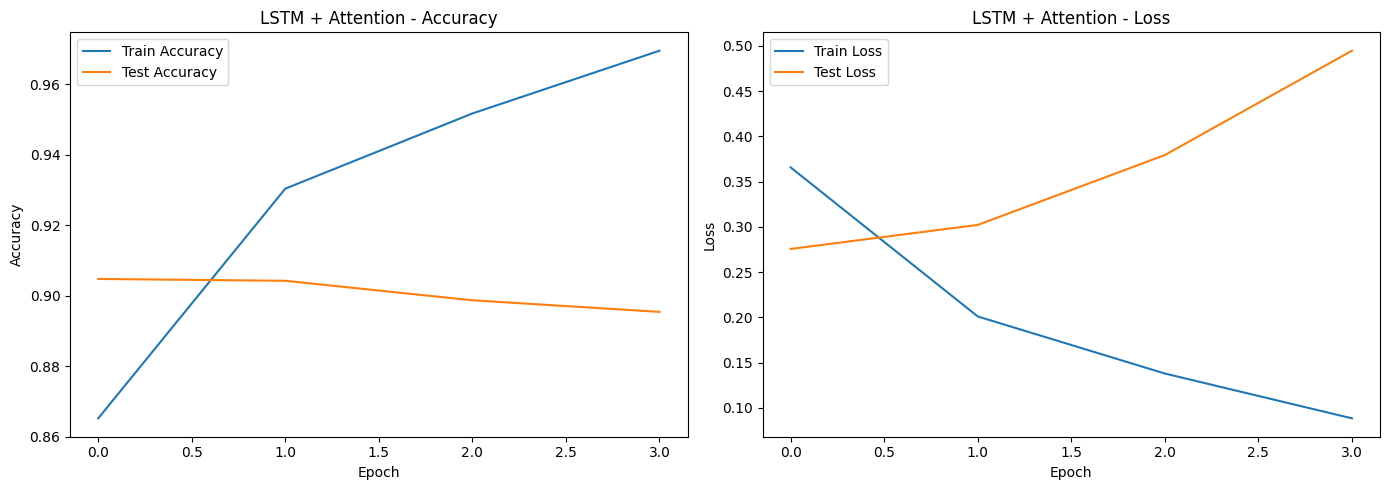

In [58]:
plot_training_history(history_lstm, 'LSTM + Attention', 'lstm_attention.png')


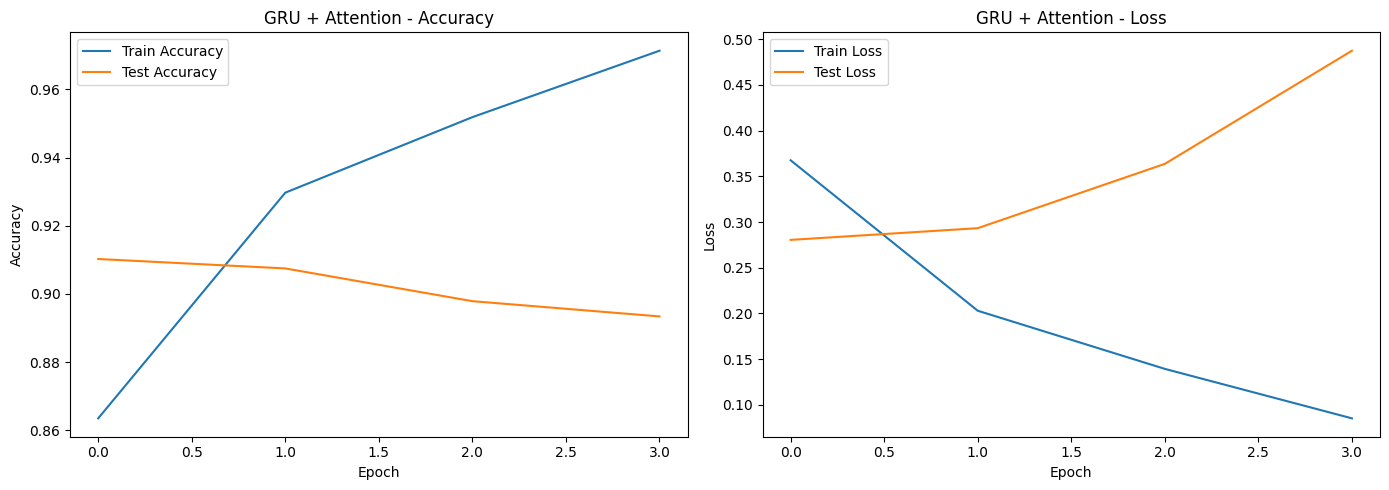

In [59]:
plot_training_history(history_gru, 'GRU + Attention', 'gru_attention.png')

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_matrix_plot(model, data):
    y_true = []
    y_pred = []
    for x_batch, y_batch in data:
        preds = model.predict(x_batch, verbose=0)
        y_true.extend(np.argmax(y_batch.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["World", "Sports", "Business", "Sci/Tech"])
    disp.plot(cmap="Blues")

2025-04-24 19:27:52.267862: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


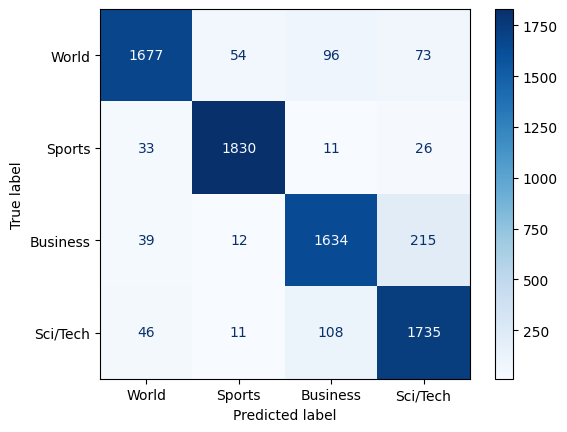

In [67]:
confusion_matrix_plot(model_lstm, test_tokenized)

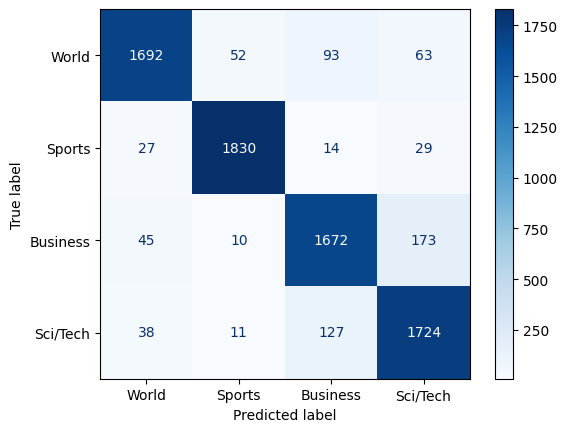

In [70]:
confusion_matrix_plot(model_gru, test_tokenized)